In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
import numpy as np
from functools import partial
from dateutil import parser as dtparser

from utils.datafetch import *
from utils.vectorized_funs import *
from utils.datapipe import *
from FintechCapstone import FinCapstone

%matplotlib inline

In [3]:
date_from = '2009-01-01'
date_to = '2017-03-01'
timespan = {
    "short_term": [1, 5]
    ,"medium_term": [40]
    ,"long_term": [90]
}

timespan_ab = {
    "short_term": []
    ,"medium_term": [30]
    ,"long_term": []
}

trial = FinCapstone(ticker_list_samplesize=10, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)

amex has 400 tickers.
nasdaq has 3081 tickers.
nyse has 3299 tickers.


Final dataset has 6780 records
(NOK) Final dataset has duplicate tickers (6779 distinct)


In [4]:
trial.run_initial_dataload()

(1/10) Recv. and Stored XXII
(2/10) Recv. and Stored FAX
(3/10) Recv. and Stored IAF
(4/10) Recv. and Stored CH
(5/10) ERROR receiving ABE           
(6/10) Recv. and Stored FCO
(7/10) Recv. and Stored IF
(8/10) Recv. and Stored ISL
(9/10) Recv. and Stored ACU
(10/10) Recv. and Stored AIII
Took 0:00:03.555939


In [5]:
trial.feature_engineering(feature_set="baseline")



 - XXII - 

| | START     - 2017-04-01 18:42:29.810419
\ / RETURNS - 0:00:00.035928
 V  END       - 2017-04-01 18:42:29.846406 (TOOK 0:00:00.035987)


 - FAX - 

| | START     - 2017-04-01 18:42:29.921859
\ / RETURNS - 0:00:00.037882
 V  END       - 2017-04-01 18:42:29.959801 (TOOK 0:00:00.037942)


 - IAF - 

| | START     - 2017-04-01 18:42:30.063916
\ / RETURNS - 0:00:00.036059
 V  END       - 2017-04-01 18:42:30.100030 (TOOK 0:00:00.036114)


 - CH - 

| | START     - 2017-04-01 18:42:30.200549
\ / RETURNS - 0:00:00.036097
 V  END       - 2017-04-01 18:42:30.236702 (TOOK 0:00:00.036153)


 - FCO - 

| | START     - 2017-04-01 18:42:30.336320
\ / RETURNS - 0:00:00.035982
 V  END       - 2017-04-01 18:42:30.372359 (TOOK 0:00:00.036039)


 - IF - 

| | START     - 2017-04-01 18:42:30.464392
\ / RETURNS - 0:00:00.036108
 V  END       - 2017-04-01 18:42:30.500555 (TOOK 0:00:00.036163)


 - ISL - 

| | START     - 2017-04-01 18:42:30.598447
\ / RETURNS - 0:00:00.035952
 V  END       - 

In [6]:
itr_ticker = "AIII"
train_from = dtparser.parse("2010-01-01")
train_until = dtparser.parse("2015-12-31")
test_from = dtparser.parse("2016-01-01")

feature_cols = ['timewindow_return_1_Open', 'timewindow_return_1_High',
       'timewindow_return_1_Low',
       'timewindow_return_1_Volume']

labels_cols = ['timewindow_return_1_Close',
        'timewindow_return_5_Close', 
        'timewindow_return_90_Close',
        'timewindow_return_40_Close']

labels_cols = ['timewindow_return_1_Close']

itr_df = load_baseline_frame(itr_ticker, parseDate=True)
itr_df.set_index("Date", inplace=True)


## Clear Infinity
for col in feature_cols:
    itr_df.loc[np.isinf(itr_df[col]), col] = 0.0
    
for col in labels_cols:
    itr_df.loc[np.isinf(itr_df[col]), col] = 0.0


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


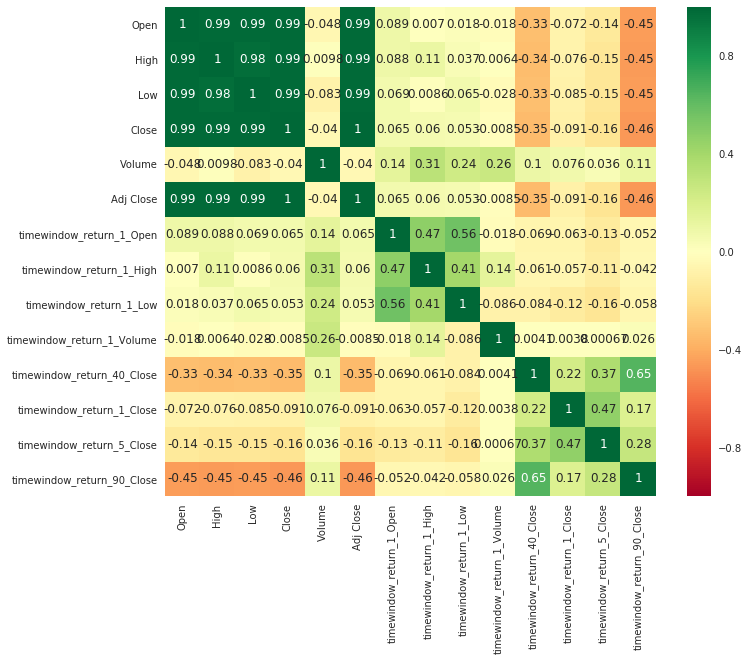

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(11, 9))

#sns.heatmap(itr_df.corr(), vmin=-1, vmax=1, cmap="RdYlGn", annot=True, ax=ax)

In [8]:
X_train = itr_df.loc[:train_until, feature_cols]
y_train = itr_df.loc[:train_until, labels_cols]
X_test = itr_df.loc[test_from:, feature_cols]
y_test = itr_df.loc[test_from:, labels_cols]

y_train = (y_train > 0.0) * 1.0
y_test = (y_test > 0.0) * 1.0



In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=2, batch_size=5)
kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)

print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", input_dim=4, kernel_initializer="normal")`
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`


Epoch 1/10


IndexError: indices are out-of-bounds